In [19]:
import numpy as np
import json
from collections import Counter
from matplotlib import pyplot as plt
import os
import pickle

In [20]:
def counter_to_array(counter, n_classes=10):
    array = np.zeros(n_classes, dtype=np.int64)
    for key, value in counter.items():
        array[key] += value
    return array

In [28]:
TASK = 'synthetic_classification_cnum10_dist10_skew0.0_seed0'

In [29]:
with open('/mnt/disk1/duongtn/ShapleyFL/fedtask/{}/data.json'.format(TASK), 'r') as f:
    data= json.load(f)

In [30]:
data.keys()

dict_keys(['store', 'client_names', 'dtest', 'Client00', 'Client01', 'Client02', 'Client03', 'Client04', 'Client05', 'Client06', 'Client07', 'Client08', 'Client09'])

In [31]:
print('test', len(data['dtest']['y']))
for client in data['client_names']:
    print(client, len(data[client]['dtrain']['y']), len(data[client]['dvalid']['y']))

test 1433
Client00 590 127
Client01 569 122
Client02 568 122
Client03 896 192
Client04 562 120
Client05 696 149
Client06 816 175
Client07 805 173
Client08 595 128
Client09 562 121


In [32]:
counter = Counter(data['dtest']['y'])
print('test', counter_to_array(counter))
for client in data['client_names']:
    counter = Counter(data[client]['dtrain']['y'])
    print(client, counter_to_array(counter))

test [226 303 471  59 121  21  75 133  22   2]
Client00 [584   0   0   6   0   0   0   0   0   0]
Client01 [  0   0   0   0 556   0   5   8   0   0]
Client02 [  0   0   0   0   0  68   0 500   0   0]
Client03 [  9   0 887   0   0   0   0   0   0   0]
Client04 [  0 263   0 293   0   0   6   0   0   0]
Client05 [  0   0 690   0   0   0   0   0   0   6]
Client06 [  0 216 491   0   0   0   0   0 109   0]
Client07 [  0 803   0   0   2   0   0   0   0   0]
Client08 [438   0   0   0   0   0   0 157   0   0]
Client09 [  0  92 126   0   7   0 336   0   0   1]


In [33]:
train_len = np.array([len(data[client]['dtrain']['y']) for client in data['client_names']])
train_len_p = train_len / train_len.sum()
train_len_p

array([0.08860189, 0.08544827, 0.08529809, 0.13455474, 0.08439706,
       0.1045202 , 0.12254092, 0.12088902, 0.08935276, 0.08439706])

In [27]:
train_len.sum()

6659

In [37]:
folder = 'fedtask/{}/record/'.format(TASK)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * len(data['client_names'])] = np.zeros(101)

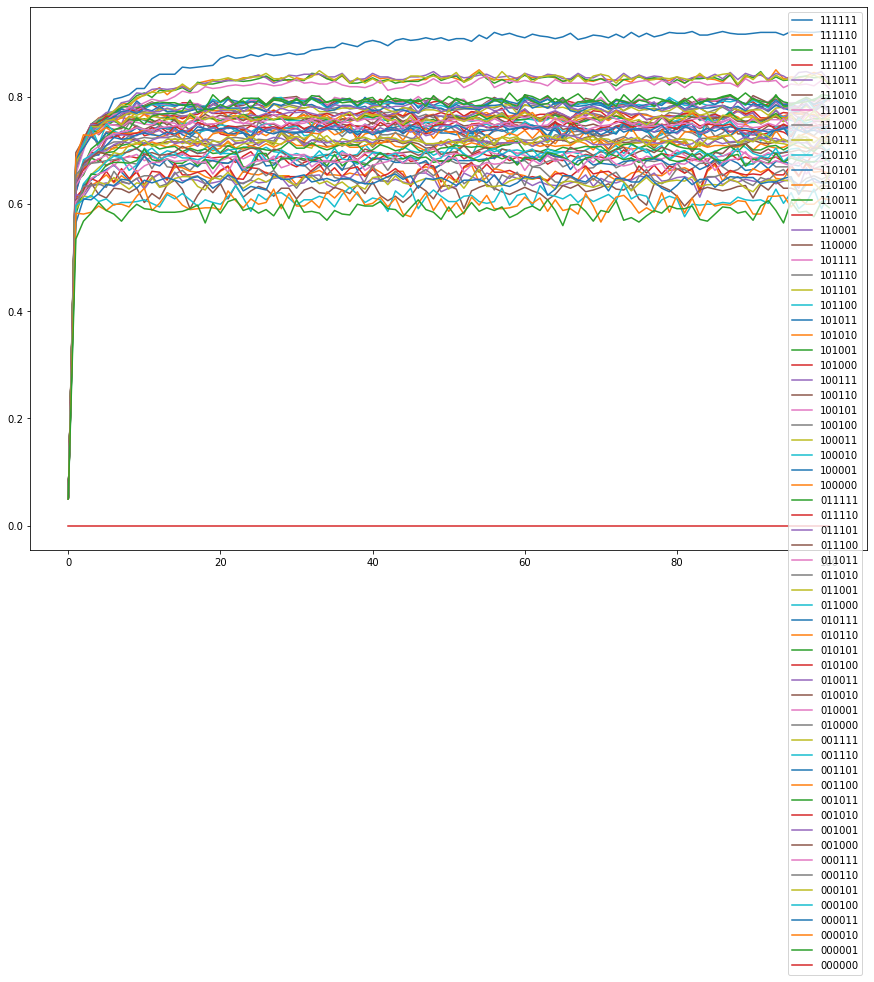

In [38]:
plt.figure(figsize=(15, 10))
for key, value in DICT.items():
    plt.plot(value[:], label=key)
plt.legend()
plt.show()

In [39]:
from bitsets import bitset
import itertools

In [40]:
CLIENTS_BITSET = bitset('clients_bitset', tuple(data['client_names']))

In [41]:
SV = dict()
for client in data['client_names']:
    result = 0.0
    rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
    for i in range(0, len(rest_clients) + 1):
        a_i = 0.0
        count_i = 0
        for subset in itertools.combinations(rest_clients, i):
            # print(subset)
            a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max()
            if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                    print(client, subset)
            # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
            count_i += 1
        # print(a_i, count_i)
        a_i = a_i / count_i
        result += a_i
    result = result / len(data['client_names'])
    SV[client] = result

In [42]:
sv = np.array(list(SV.values()))
sv = sv / sv.sum()
sv

array([0.2245045 , 0.17840841, 0.15465465, 0.14936937, 0.15099099,
       0.14207207])

In [43]:
sum(SV.values())

0.9219269102990035

In [81]:
accuracy = list()
exact = list()
const_lambda = list()
optimal_lambda = dict()
for round_ in range(1, 101):
    # with open('SV_result/{}/min_max/minRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     min_v = pickle.load(f)
    min_v = 0.0
    # with open('SV_result/{}/min_max/maxRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     max_v = pickle.load(f)
    max_v = 1.0
    with open('SV_result/{}/client_accuracy/Round{}.npy'.format(TASK, round_), 'rb') as f:
        accuracy.append((pickle.load(f) / (max_v - min_v)).tolist())
    with open('SV_result/{}/exact/Round{}.npy'.format(TASK, round_), 'rb') as f:
        exact.append((pickle.load(f) / (max_v - min_v)).tolist())
    with open('SV_result/{}/const_lambda/Round{}.npy'.format(TASK, round_), 'rb') as f:
        const_lambda.append((pickle.load(f) / (max_v - min_v)).tolist())
    for ns in [30, 40, 50, 60, 63]:
        if ns not in optimal_lambda.keys():
            optimal_lambda[ns] = list()
        with open('SV_result/{}/optimal_lambda-{}/Round{}.npy'.format(TASK, ns, round_), 'rb') as f:
            optimal_lambda[ns].append((pickle.load(f) / (max_v - min_v)).tolist())
exact = np.array(exact)
const_lambda = np.array(const_lambda)
for key in optimal_lambda.keys():
    optimal_lambda[key] = np.array(optimal_lambda[key])
exact.shape, const_lambda.shape, *[opt.shape for opt in optimal_lambda.values()]

((100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6), (100, 6))

In [83]:
accuracy = np.array(accuracy)

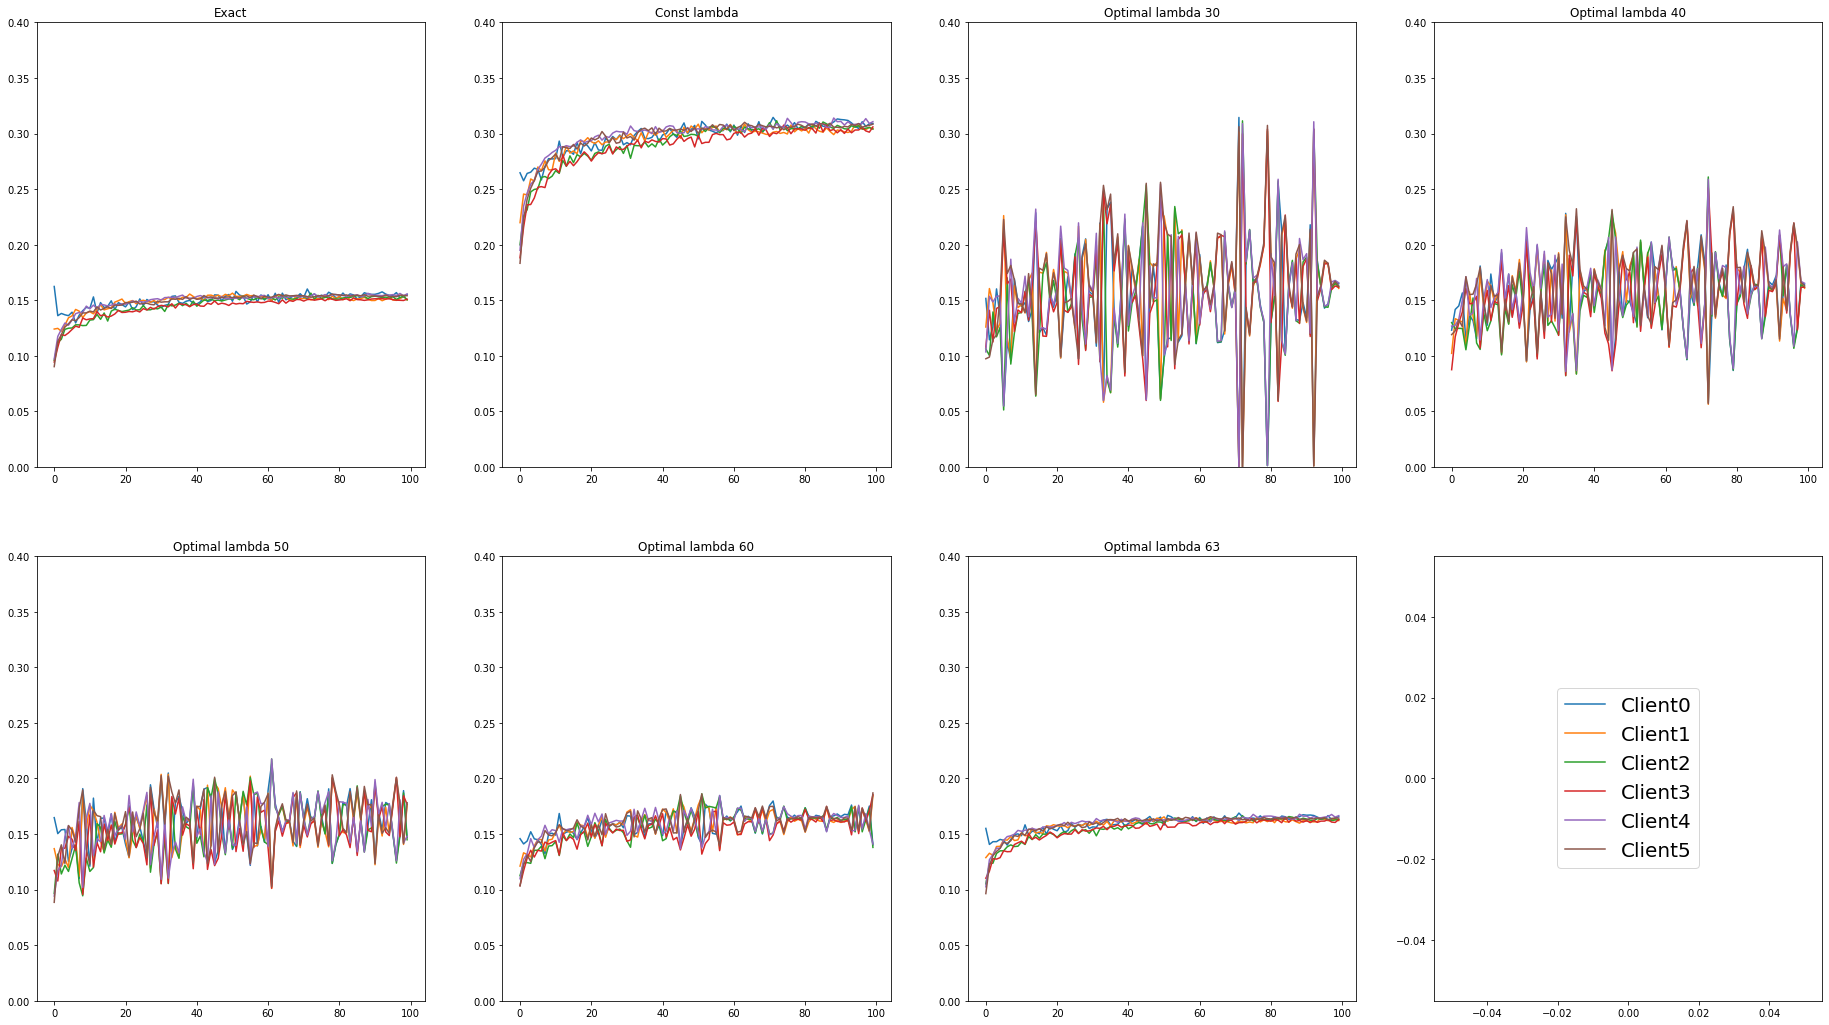

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(18)
fig.set_figwidth(32)
ax[0, 0].set_title('Exact')
ax[0, 0].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], exact.T):
    ax[0, 0].plot(clients_sv[:], label=client)
ax[0, 1].set_title('Const lambda')
ax[0, 1].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], const_lambda.T):
    ax[0, 1].plot(clients_sv[:], label=client)
ax[0, 2].set_title('Optimal lambda 30')
ax[0, 2].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], optimal_lambda[30].T):
    ax[0, 2].plot(clients_sv[:], label=client)
ax[0, 3].set_title('Optimal lambda 40')
ax[0, 3].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], optimal_lambda[40].T):
    ax[0, 3].plot(clients_sv[:], label=client)
ax[1, 0].set_title('Optimal lambda 50')
ax[1, 0].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], optimal_lambda[50].T):
    ax[1, 0].plot(clients_sv[:], label=client)
ax[1, 1].set_title('Optimal lambda 60')
ax[1, 1].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], optimal_lambda[60].T):
    ax[1, 1].plot(clients_sv[:], label=client)
ax[1, 2].set_title('Optimal lambda 63')
ax[1, 2].set_ylim((0, 0.4))
for client, clients_sv in zip(data['client_names'], optimal_lambda[63].T):
    ax[1, 2].plot(clients_sv[:], label=client)
for client, clients_sv in zip(data['client_names'], optimal_lambda[63].T):
    ax[1, 3].plot(clients_sv[:0], label=client)
ax[1, 3].legend(loc='center', fontsize=20)
plt.show()

In [55]:
print("const lambda", np.abs(exact - const_lambda).sum())
for key, value in optimal_lambda.items():
    print("optimal lambda", key, np.abs(exact - value).sum())

const lambda 88.1594684385382
optimal lambda 30 22.092208569566992
optimal lambda 40 15.095737575217314
optimal lambda 50 11.365219293818171
optimal lambda 60 6.74581278860301
optimal lambda 63 5.984172118721114


In [66]:
def minmax_scale(values):
    result = list()
    for value in values:
        result.append(((value - value.min()) / (value.max() - value.min())).tolist())
    return np.array(result)

In [56]:
def aggregate(values, exp=None, alpha=None):
    result = np.zeros(values.shape[1])
    if alpha is None:
        if exp is None:
            result = values.sum(axis=0)
        else:
            for i, value in enumerate(values):
                result += value / pow(i + 1, exp)
    else:
        for i, value in enumerate(values):
            result += value * pow(alpha, i)
    # if result.min() < 0.0:
    #     result = result - result.min()
    result = result / result.sum()
    return result

In [57]:
corrs = list()
for alpha in np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01):
    e = aggregate(exact, alpha=alpha)
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01)[corrs.argmax()]

0.0

In [58]:
corrs = list()
for exp in np.arange(start=0, stop=10 + 1e-6, step=0.1):
    e = aggregate(exact, exp=exp)
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=0, stop=10 + 1e-6, step=0.1)[corrs.argmax()]

10.0

In [59]:
corrs = list()
for round_ in np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int):
    e = aggregate(exact[:round_])
    corrs.append(np.corrcoef(e, sv)[0, 1])
corrs = np.array(corrs)
np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int)[corrs.argmax()]

1

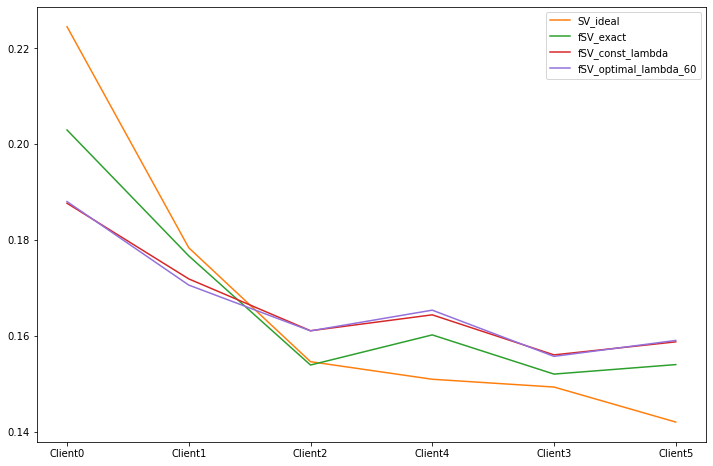

In [60]:
plt.figure(figsize=(12, 8))
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:blue')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact, exp=1.5)[np.argsort(sv)[::-1]], label='fSV_exact', color='tab:green')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(const_lambda, exp=1.5)[np.argsort(sv)[::-1]], label='fSV_const_lambda', color='tab:red')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[30], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_30', color='pink')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[40], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_40', color='plum')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[50], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_50', color='violet')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[60], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_60', color='mediumpurple')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[63], exp=1.5)[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_63', color='tab:purple')
plt.legend()
plt.show()

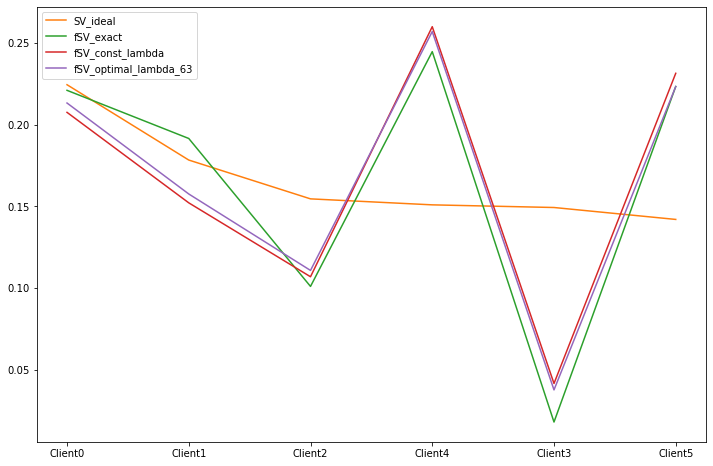

In [70]:
plt.figure(figsize=(12, 8))
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:blue')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(minmax_scale(exact[:]))[np.argsort(sv)[::-1]], label='fSV_exact', color='tab:green')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(minmax_scale(const_lambda[:]))[np.argsort(sv)[::-1]], label='fSV_const_lambda', color='tab:red')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[30][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_30', color='pink')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[40][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_40', color='plum')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[50][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_50', color='violet')
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(optimal_lambda[60][:])[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_60', color='mediumpurple')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(minmax_scale(optimal_lambda[63][:]))[np.argsort(sv)[::-1]], label='fSV_optimal_lambda_63', color='tab:purple')
plt.legend()
plt.show()

In [71]:
a = np.array([1, 2])
a

array([1, 2])

In [86]:
exact[0]

array([0.16243079, 0.12414175, 0.09590255, 0.09443522, 0.09720377,
       0.09033776])

In [87]:
accuracy[0]

array([0.68604651, 0.63621262, 0.58637874, 0.58471761, 0.57973422,
       0.55647841])

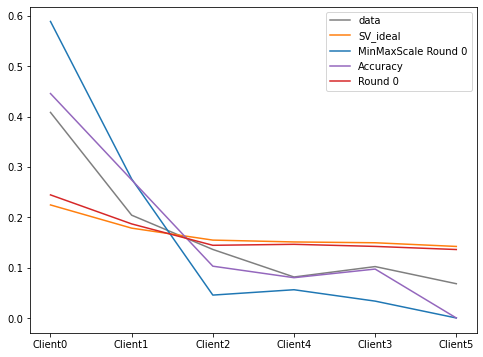

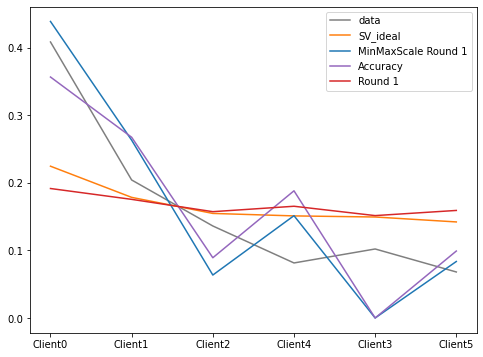

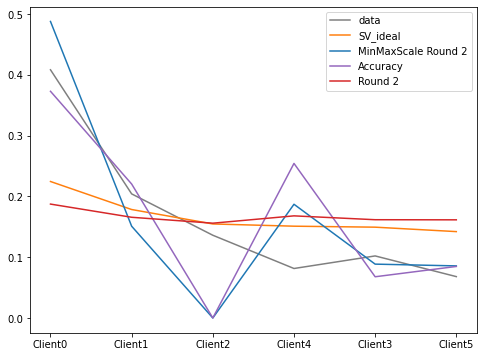

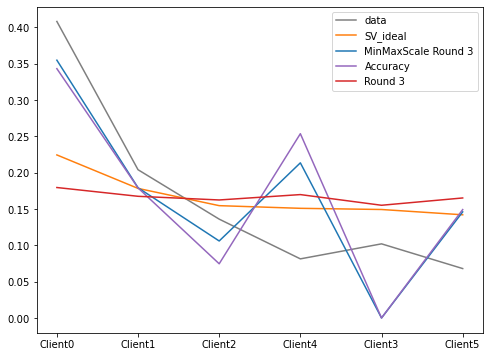

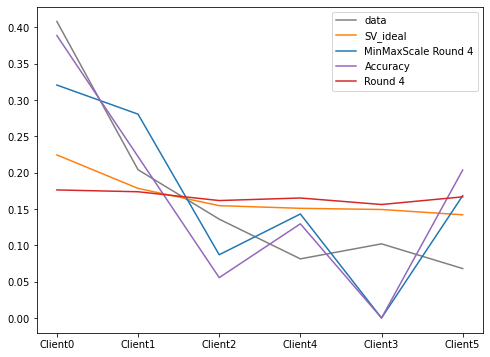

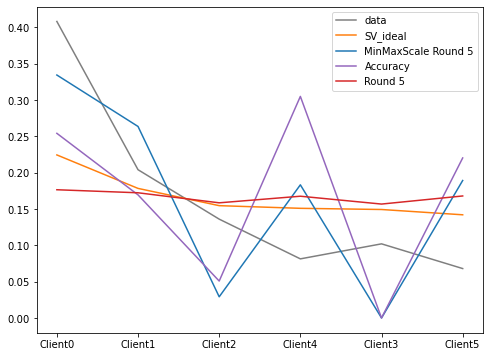

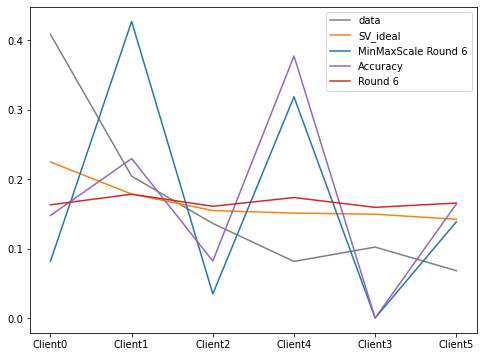

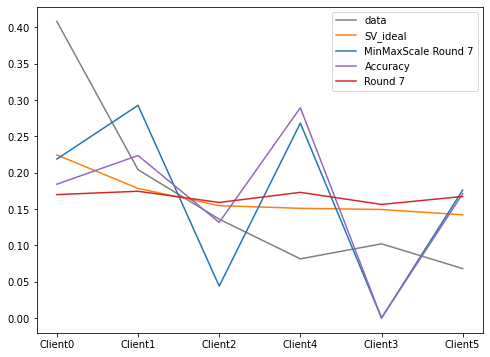

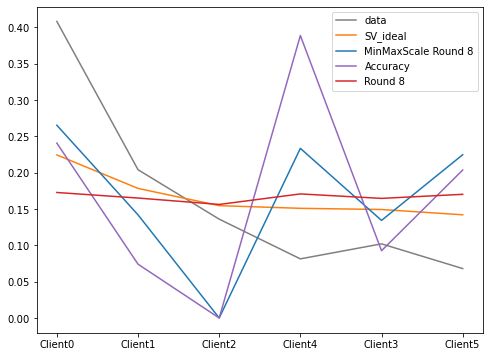

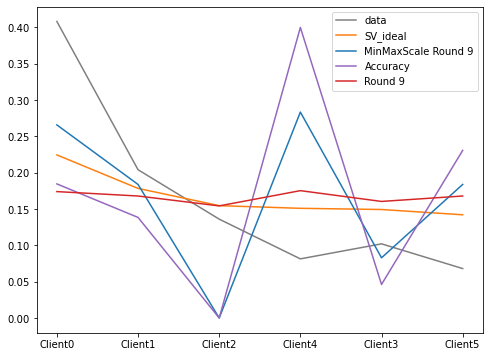

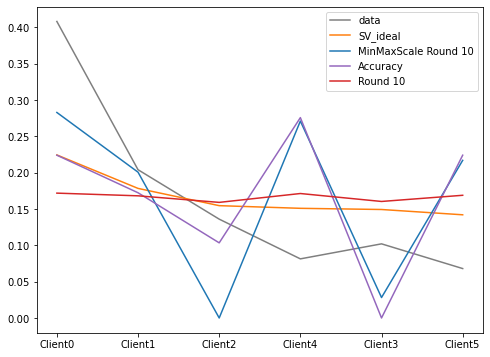

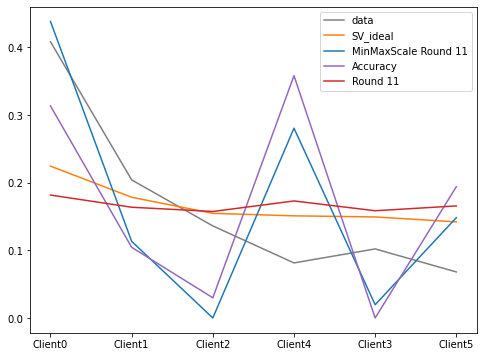

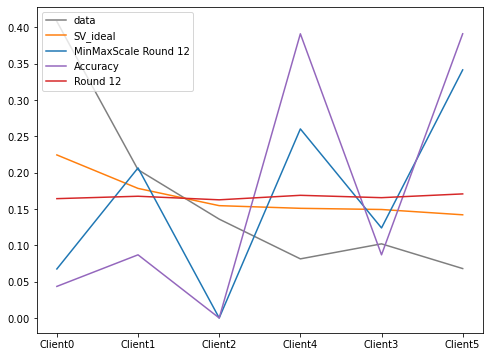

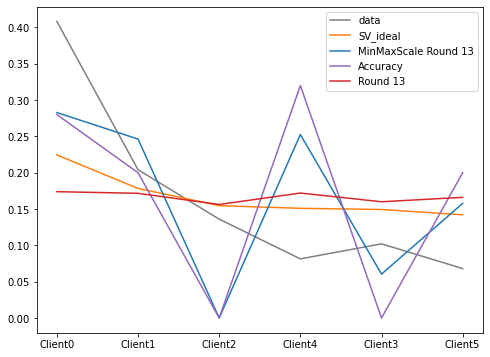

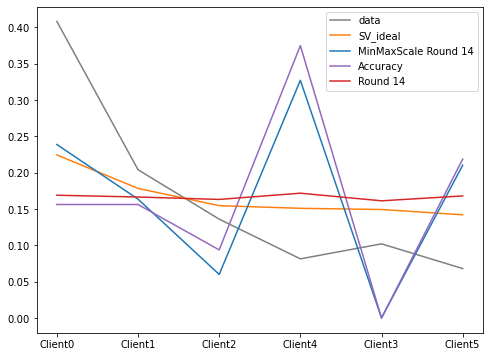

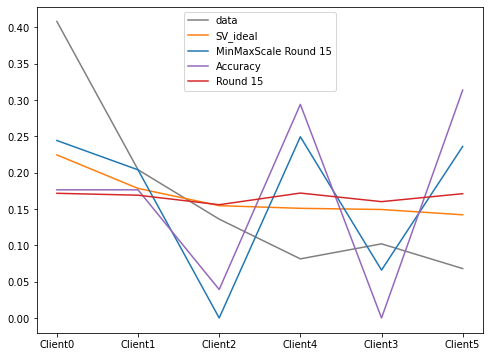

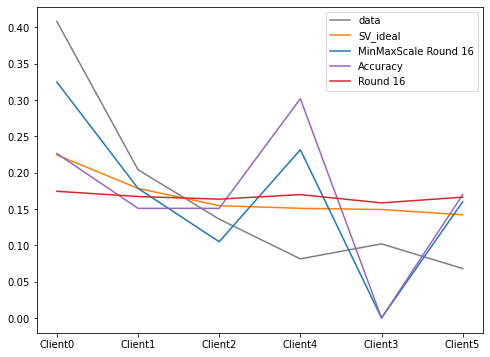

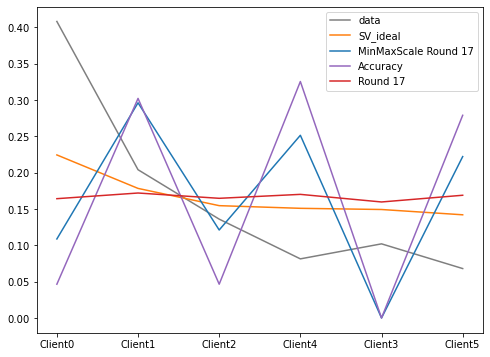

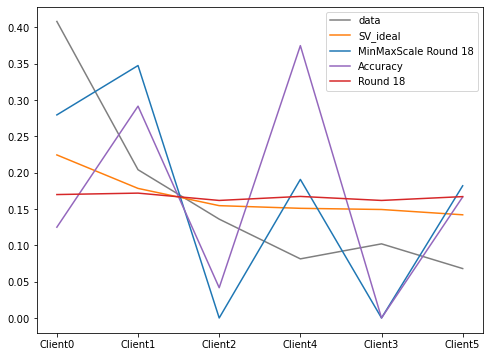

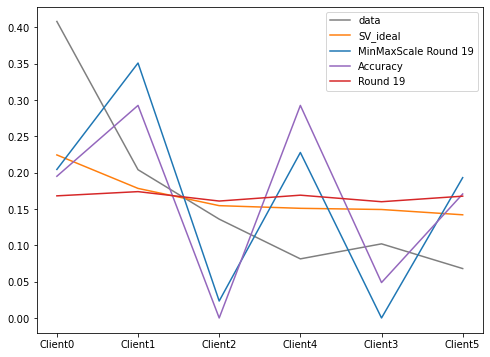

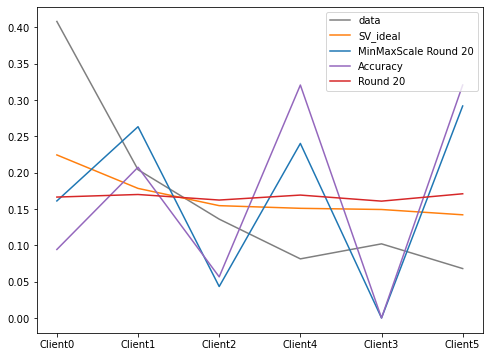

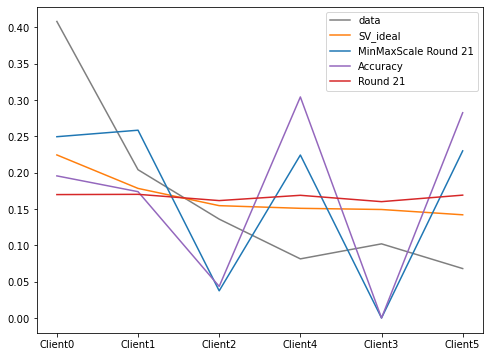

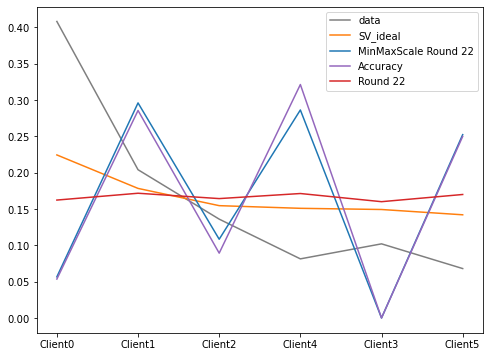

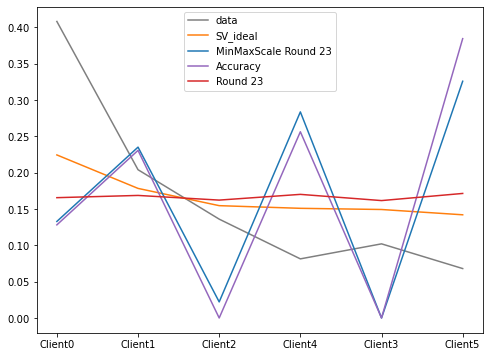

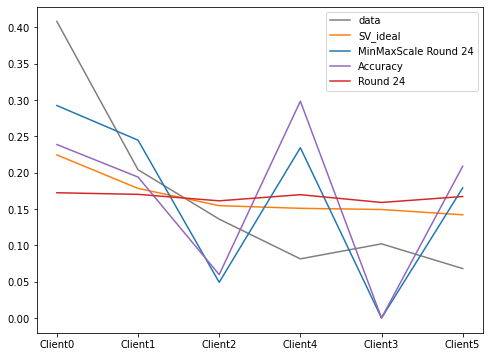

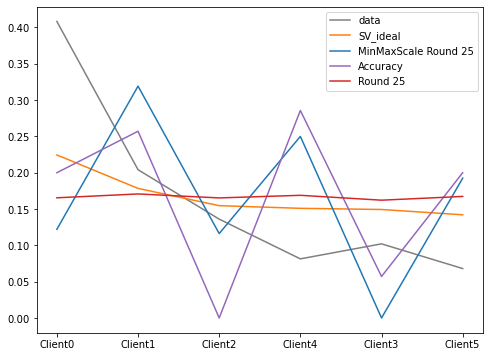

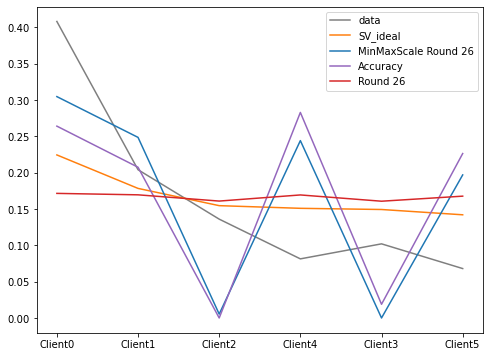

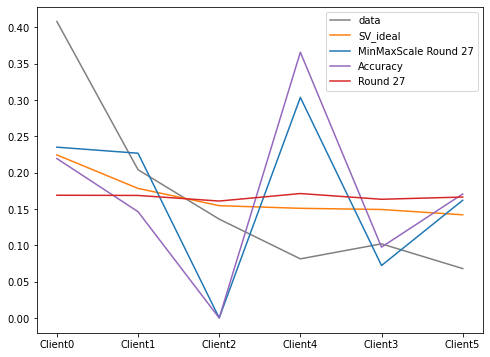

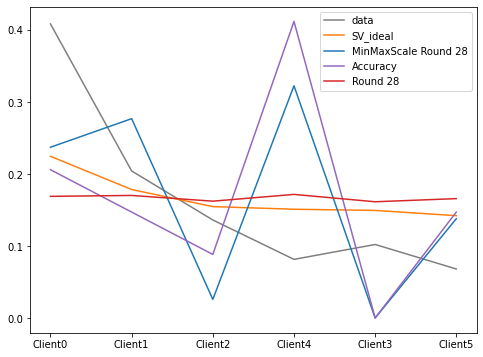

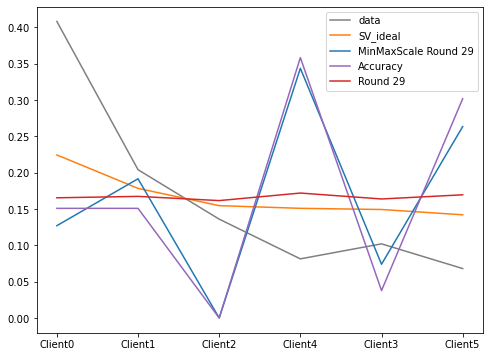

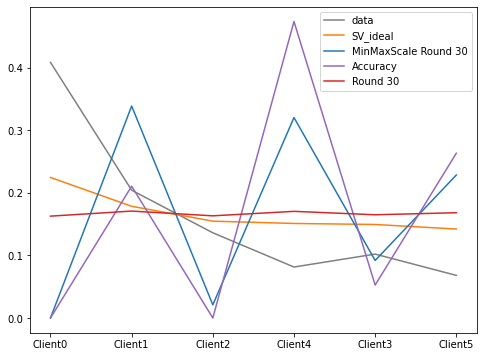

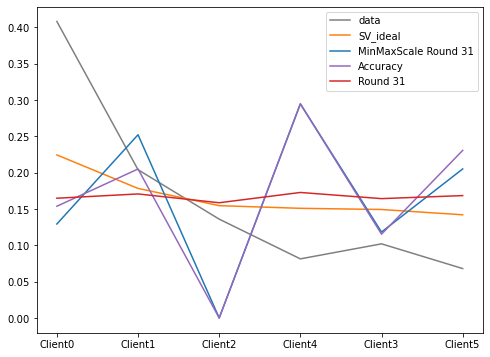

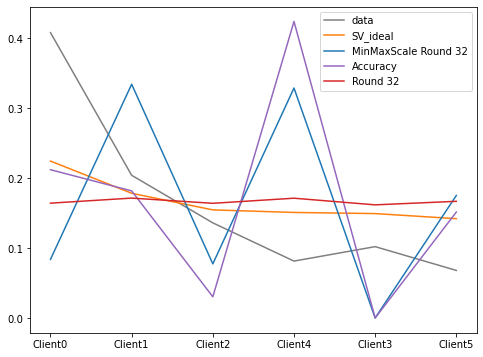

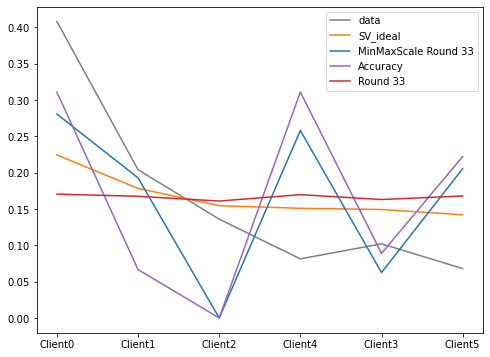

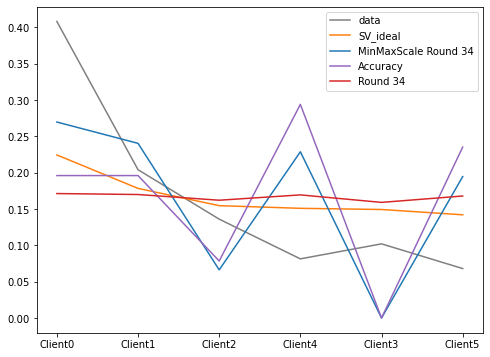

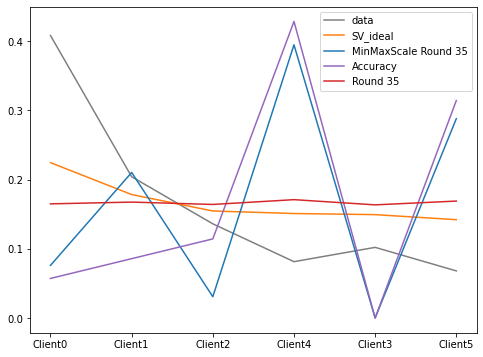

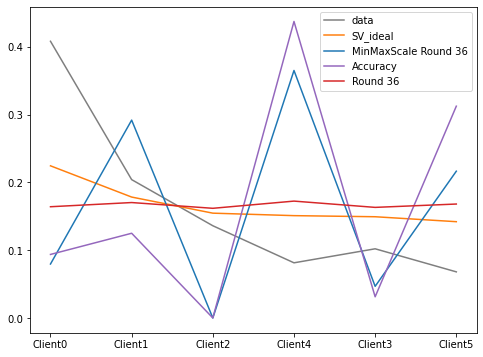

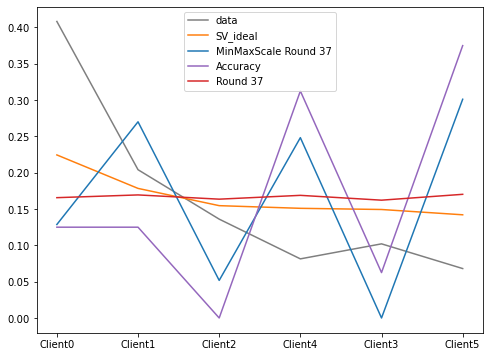

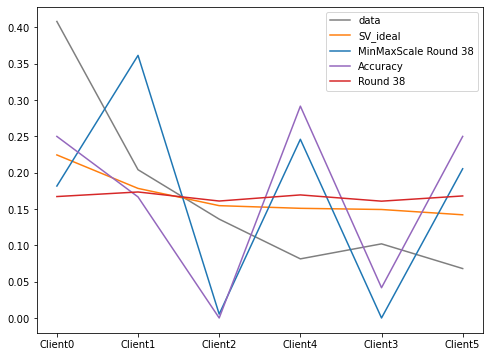

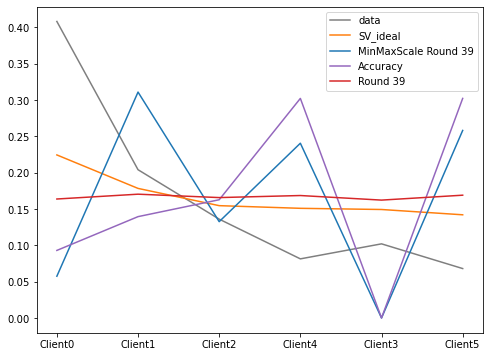

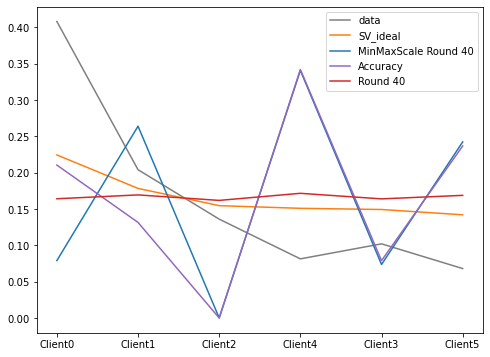

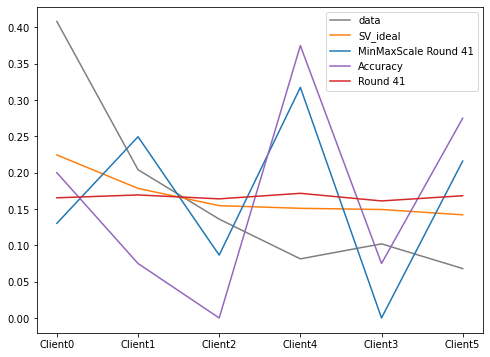

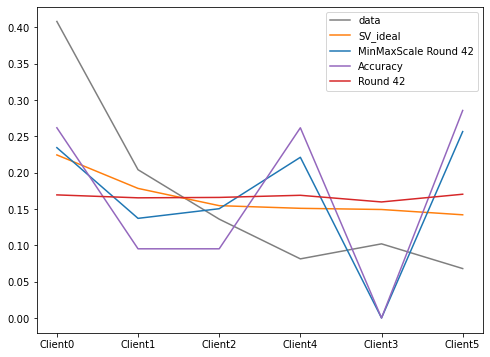

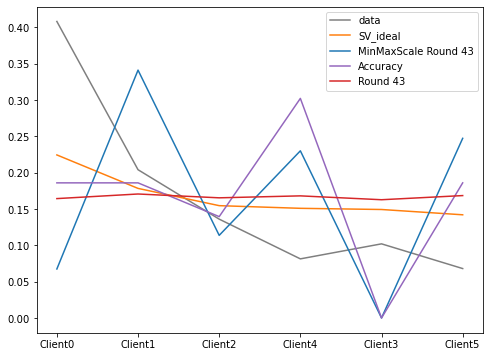

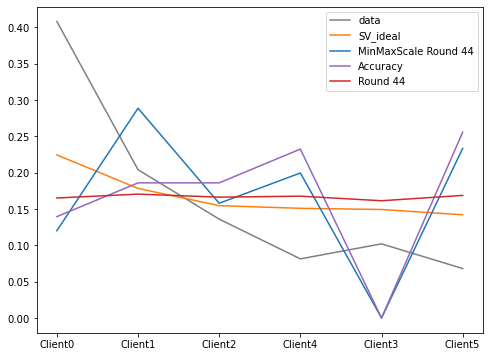

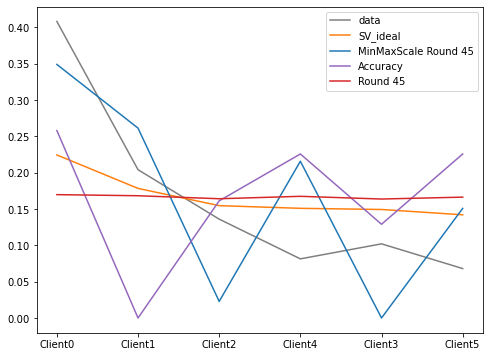

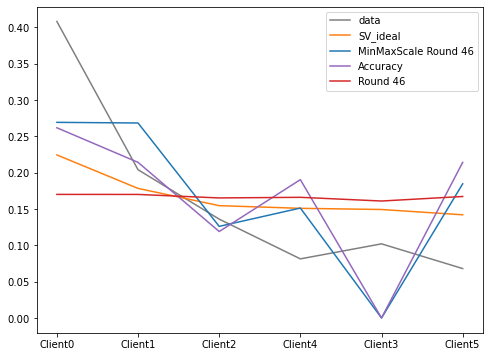

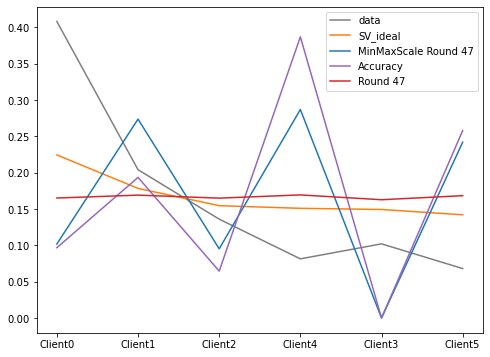

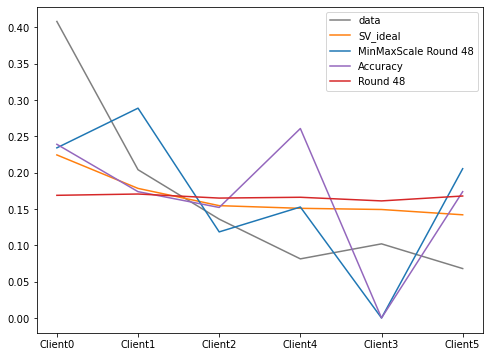

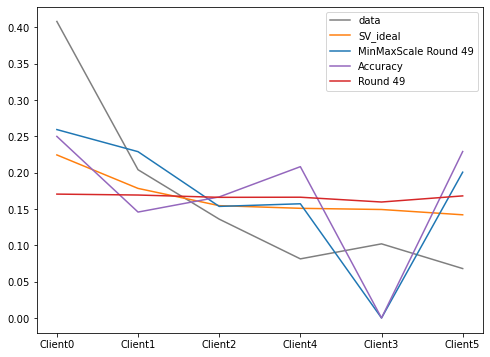

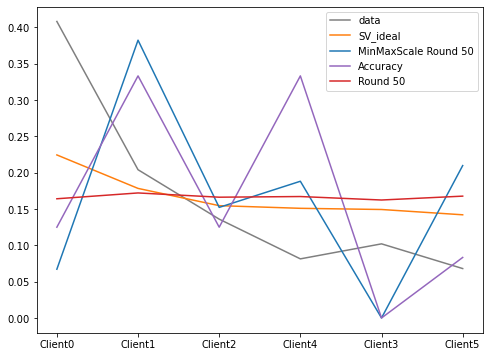

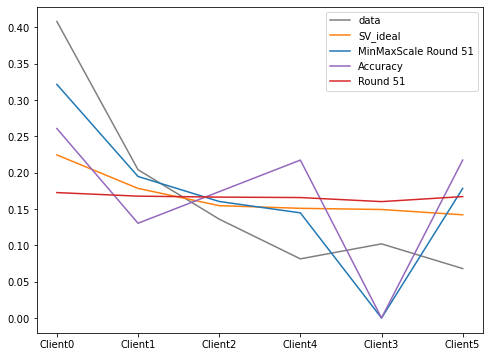

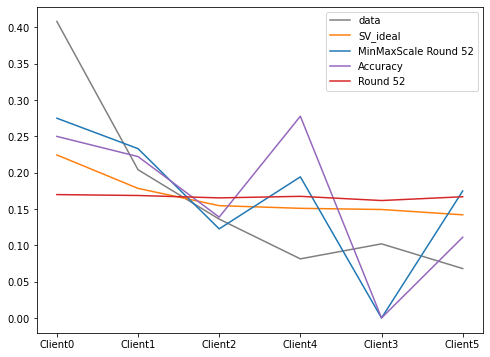

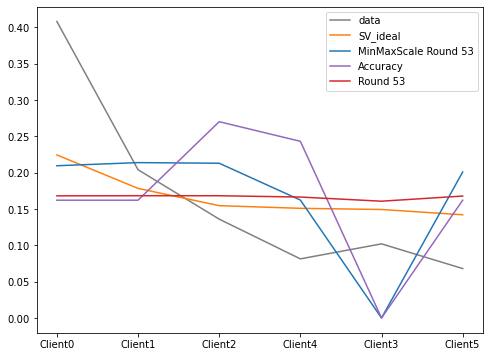

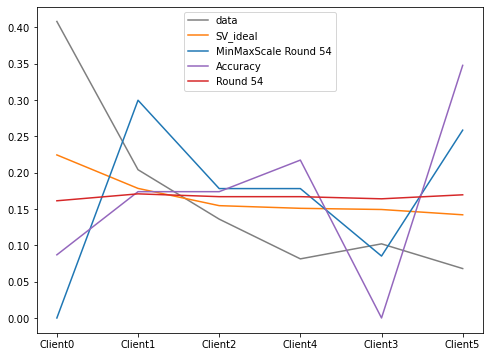

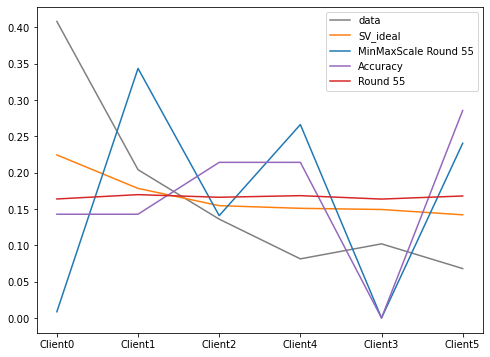

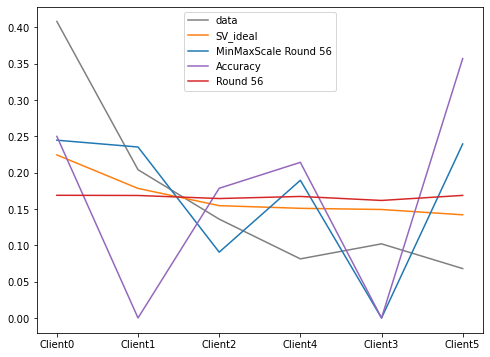

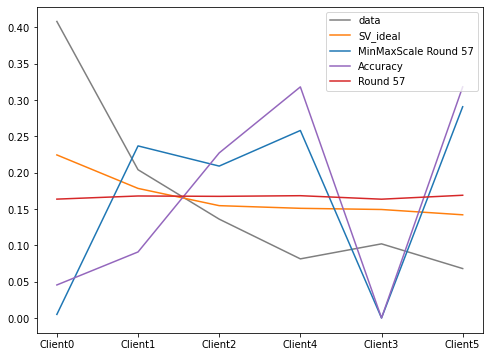

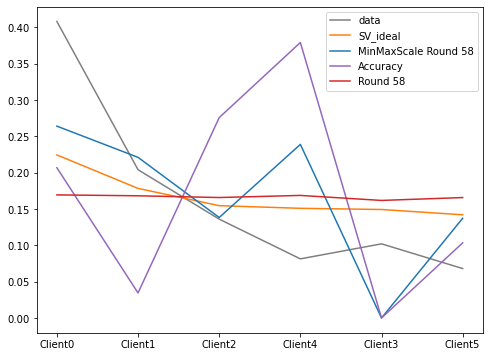

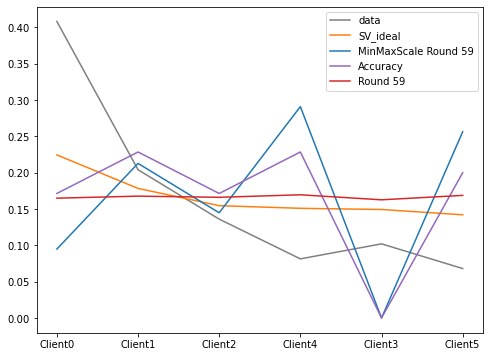

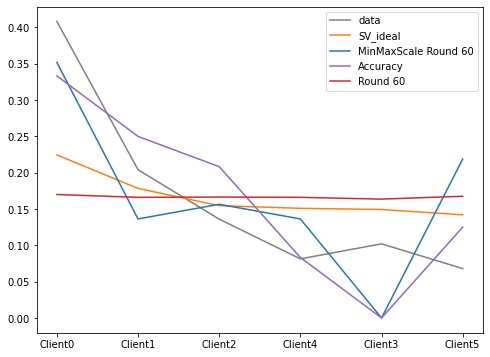

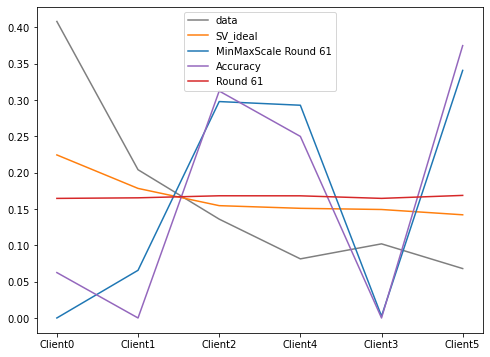

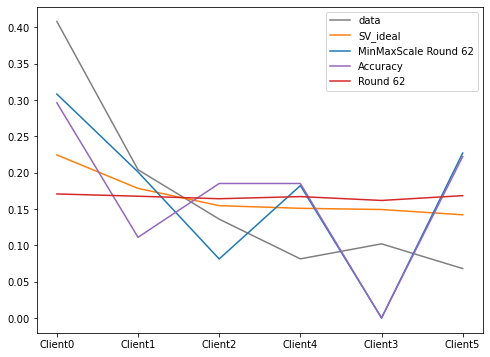

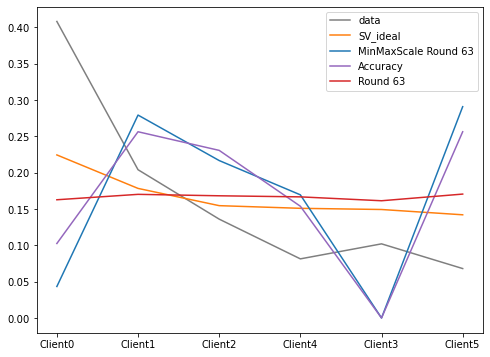

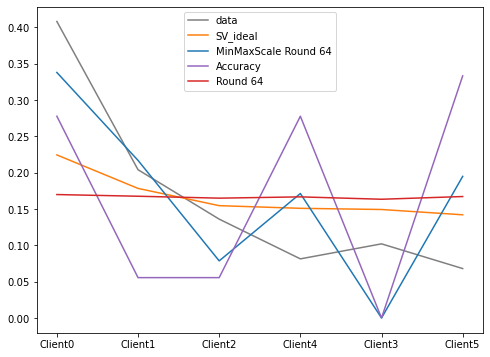

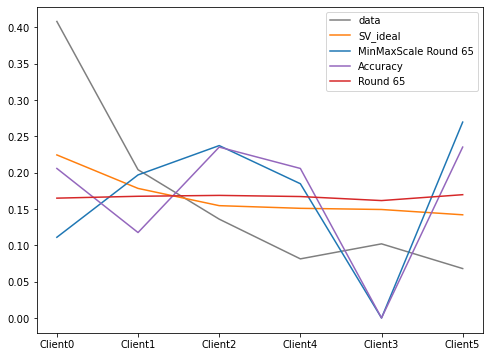

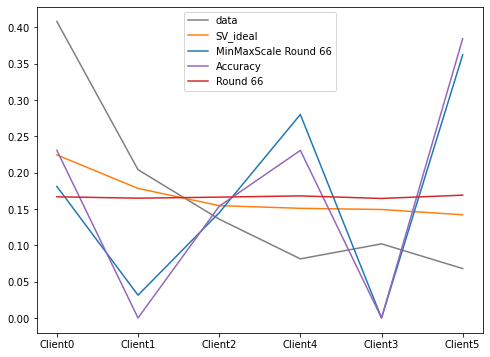

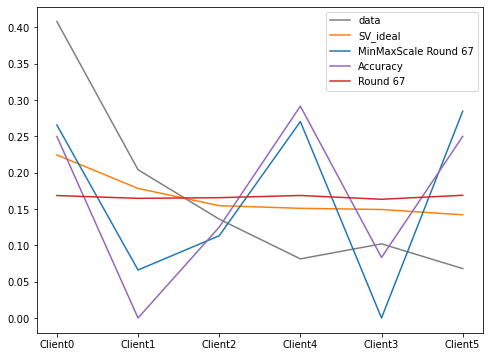

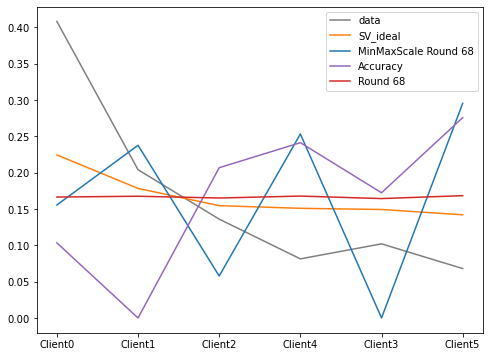

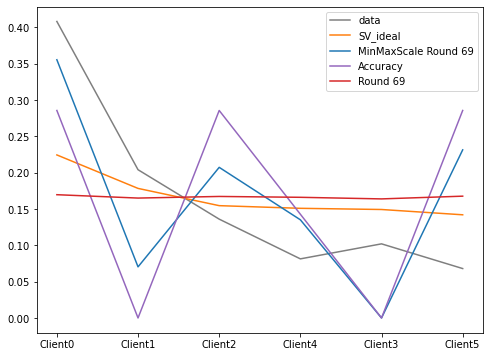

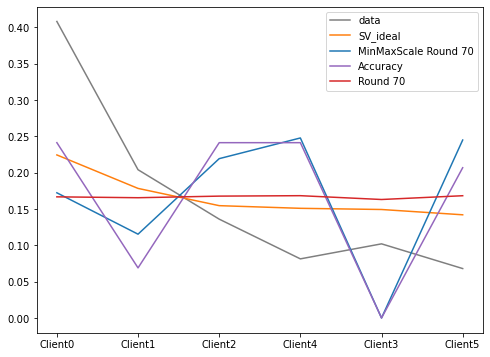

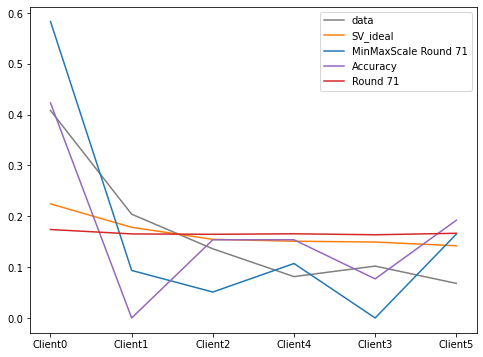

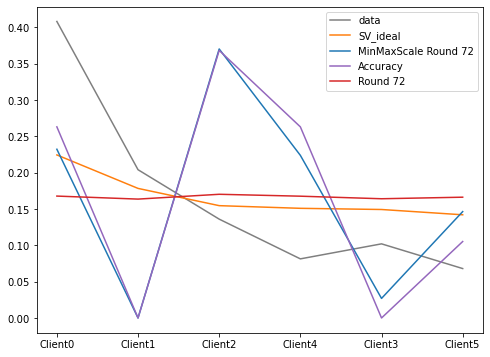

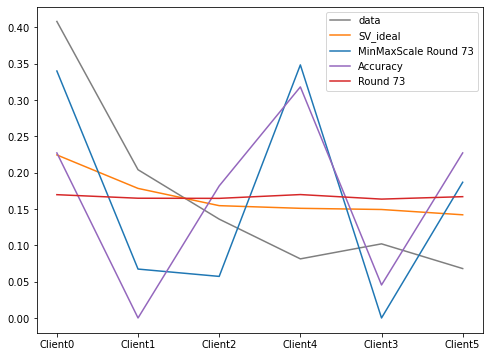

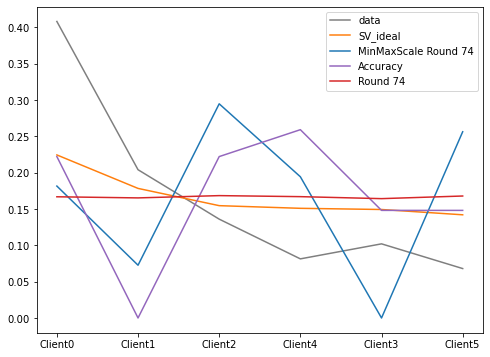

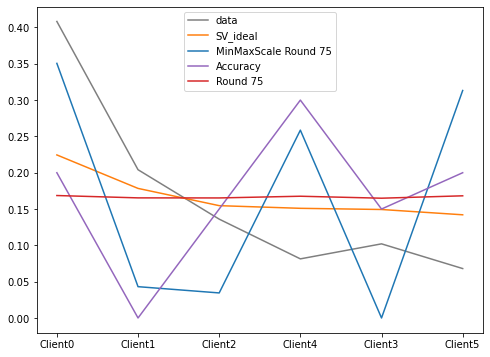

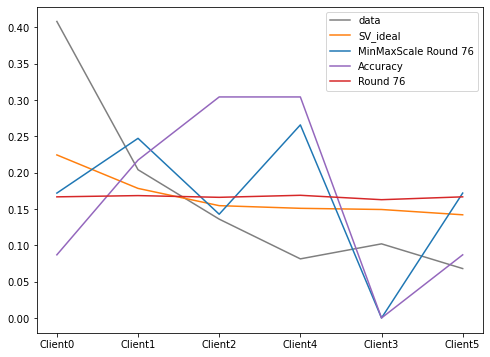

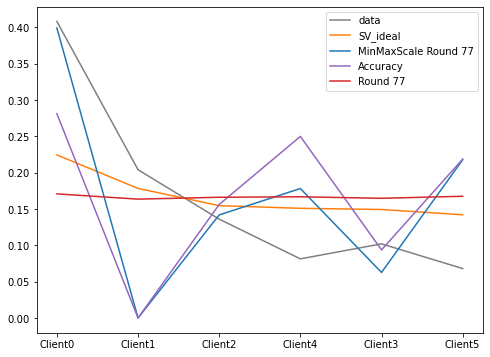

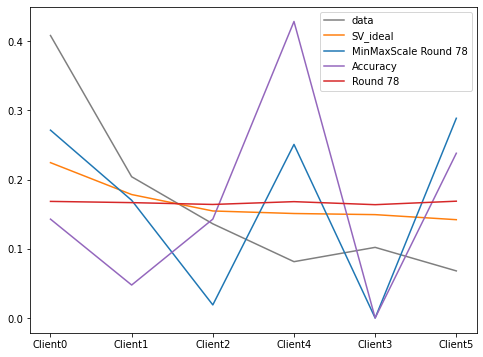

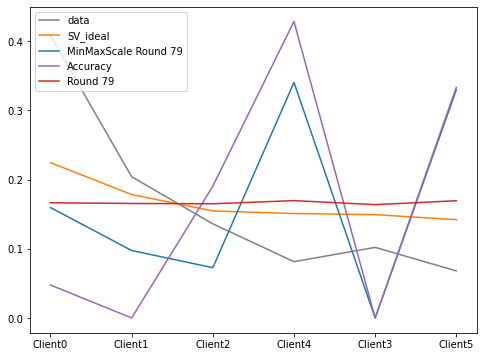

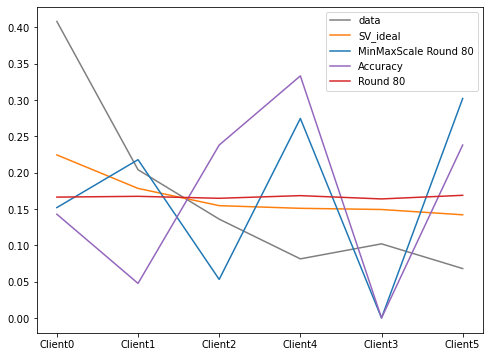

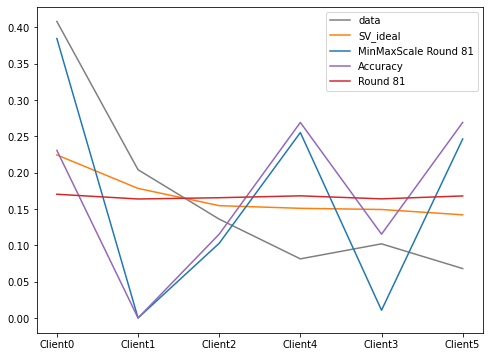

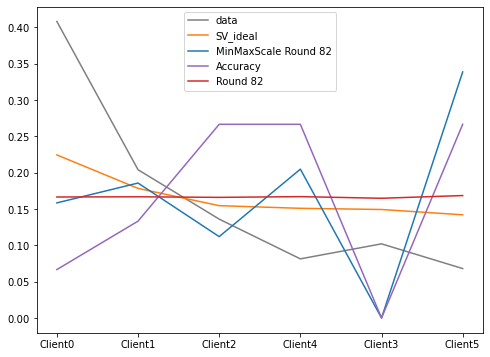

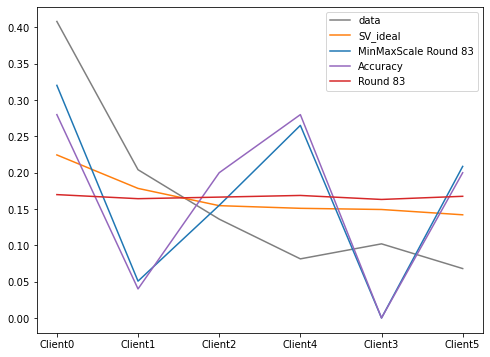

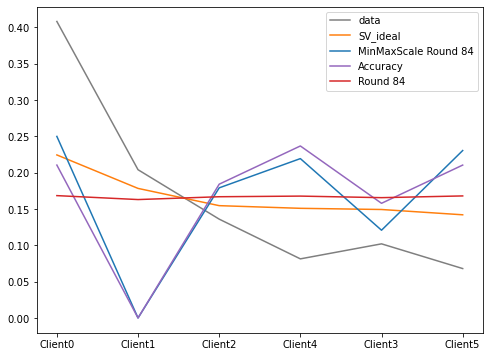

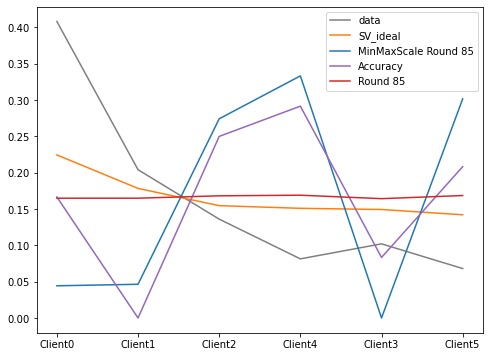

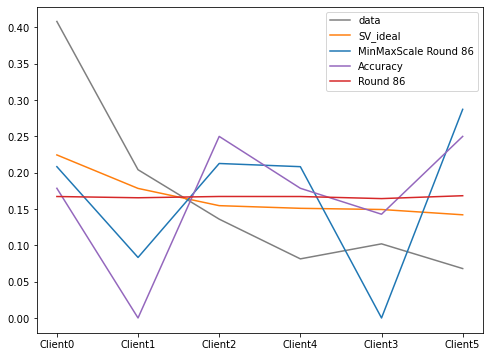

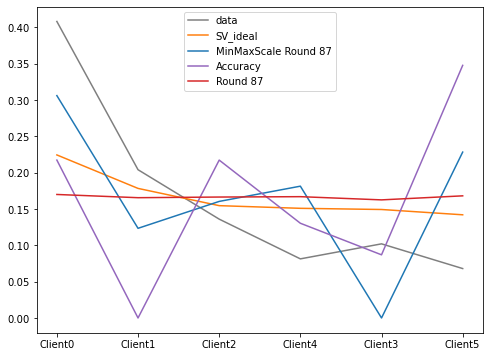

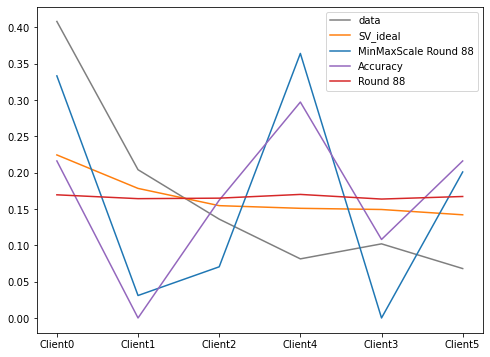

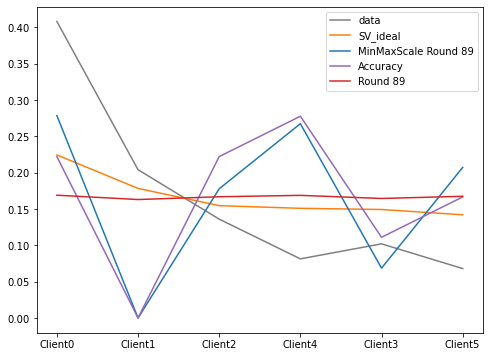

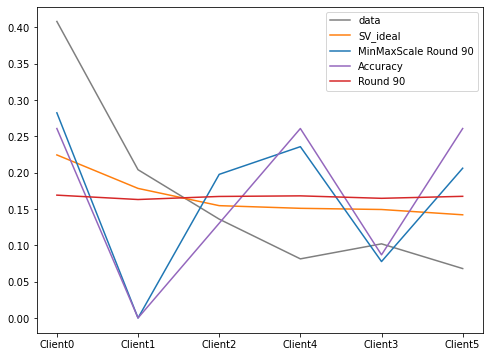

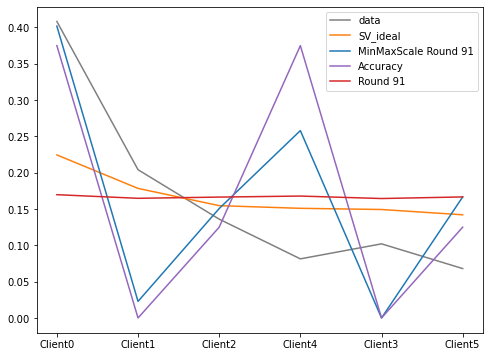

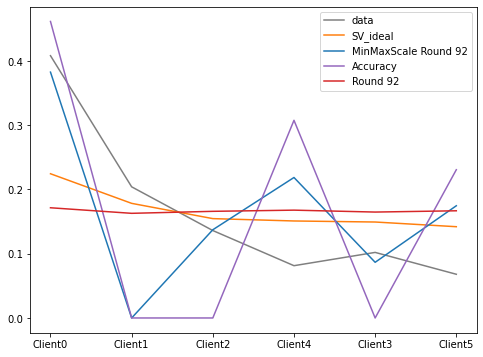

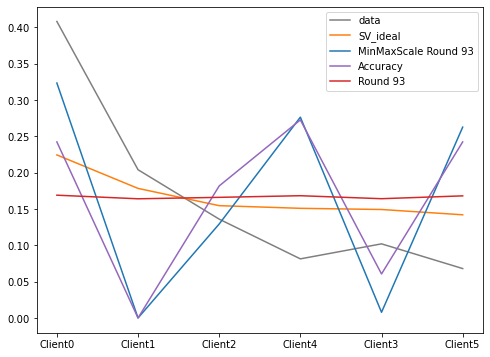

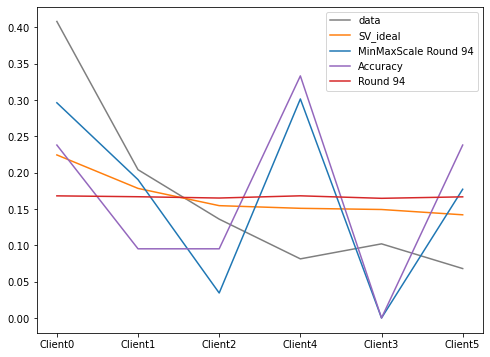

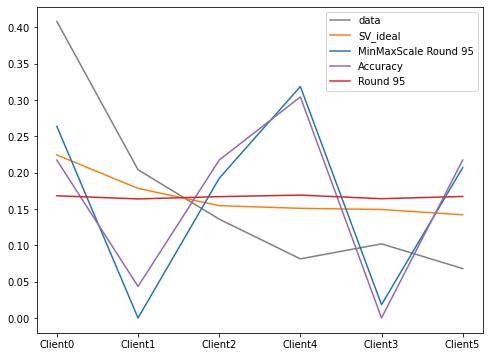

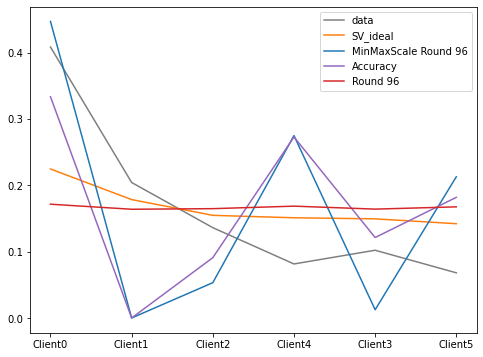

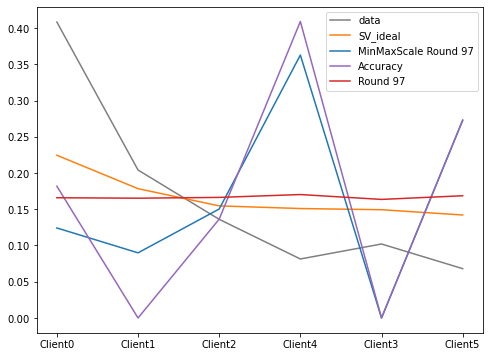

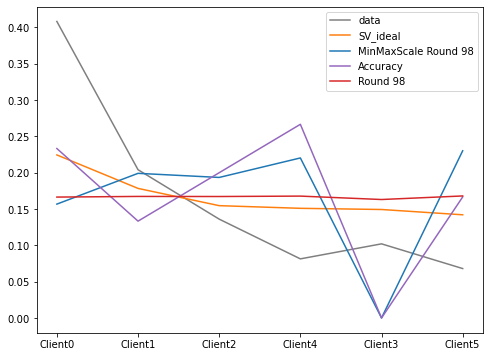

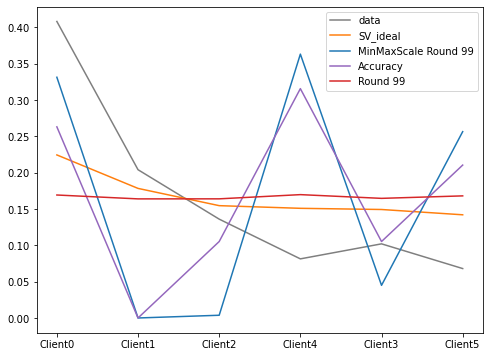

In [88]:

for i, e in enumerate(exact[:]):
    plt.figure(figsize=(8, 6))
    plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:gray')
    plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
    plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
             aggregate(minmax_scale(np.expand_dims(e, axis=0)))[np.argsort(sv)[::-1]], label='MinMaxScale Round {}'.format(i))
    plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
             aggregate(minmax_scale(np.expand_dims(accuracy[i], axis=0)))[np.argsort(sv)[::-1]], label='Accuracy', color='tab:purple')
    plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
             aggregate(np.expand_dims(e, axis=0))[np.argsort(sv)[::-1]], label='Round {}'.format(i), color='tab:red')
    plt.legend()
    plt.show()